# NLP-Milestone
many-to-one task : 
- long sentences -> Objective of sentence


In [1]:
import matplotlib.pyplot as plt
from tensorflow import keras
import pandas as pd
import numpy as np
import os

Get data : [PubMed200k RCT](https://github.com/Franck-Dernoncourt/pubmed-rct)

In [5]:
# start with 20k dataset with replace number by @ sign
data_dir = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign'
filepath = [ os.path.join(data_dir, file) for file in os.listdir(data_dir) ]
filepath

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign\\dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign\\test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign\\train.txt']

## Preprocess data

In [50]:
# read in all line of target text file
def get_lines(filepath):
    '''
    Read text file and return the lines as a list.
    '''
    with open(filepath, 'r') as file :
        return file.readlines()


train_lines = get_lines(filepath[2])
print(train_lines[:5])

['###24293578\n', 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n', 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n', 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n', 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n']


In [7]:
len(train_lines)

210040

```
[{'line_number' : 0 ,
   'target' : 'OBJECTIVE',
   'text' : 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .'
   'total_lines' : 5}, # total lines in each Abstract
   {''line_number' : 1, 
   .....
}]
```

In [39]:
def preprocess_text(filepath):
    '''
    change long lines to this format
    [{'line_number' : 0 ,
    'target' : 'OBJECTIVE',
    'text' : 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in 
              improving pain , mobility , and systemic low-grade inflammation in the short term 
              and whether the effect would be sustained at @ weeks in older adults with moderate 
              to severe knee osteoarthritis ( OA ) .'
    'total_lines' : 5}, # total lines in each Abstract
    {''line_number' : 1, 
    .....
    }]
    '''
    input_lines = get_lines(filepath)
    abstract_lines = '' # to save 1 abstract 
    abstract_samples = []

    for line in input_lines :
        if line.startswith('###') : #heading of each Abstract
            abstract_id = line 
            abstract_lines = '' # reset old Abstract
        elif line.isspace(): # if a new line (last abstract has space)
            abstract_split = abstract_lines.splitlines() # split Abstract into seperate line

            # loop for content in each Abstract
            for abstract_line_number, abstract_line in enumerate(abstract_split) :
                line_data = {} # for each target and text
                target_text = abstract_line.split('\t') # target and text
                line_data['line_number'] = abstract_line_number
                line_data['target'] = target_text[0]
                line_data['text'] = target_text[1].lower()
                line_data['total_lines'] = len(abstract_split) - 1 # start from zero
                abstract_samples.append(line_data) # add to list

        # content for each abtract
        else :
            abstract_lines += line

    return abstract_samples

In [52]:
train_samples = preprocess_text(filepath[2])
val_samples = preprocess_text(filepath[0])
test_samples = preprocess_text(filepath[1])
train_samples[9:13]

[{'line_number': 9,
  'target': 'RESULTS',
  'text': 'these differences remained significant at @ weeks .',
  'total_lines': 11},
 {'line_number': 10,
  'target': 'RESULTS',
  'text': 'the outcome measures in rheumatology clinical trials-osteoarthritis research society international responder rate was @ % in the intervention group and @ % in the placebo group ( p < @ ) .',
  'total_lines': 11},
 {'line_number': 11,
  'target': 'CONCLUSIONS',
  'text': 'low-dose oral prednisolone had both a short-term and a longer sustained effect resulting in less knee pain , better physical function , and attenuation of systemic inflammation in older patients with knee oa ( clinicaltrials.gov identifier nct@ ) .',
  'total_lines': 11},
 {'line_number': 0,
  'target': 'BACKGROUND',
  'text': 'emotional eating is associated with overeating and the development of obesity .',
  'total_lines': 10}]

In [41]:
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [55]:
# Create DataFrame
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11
2,2,METHODS,outcome measures included pain reduction and i...,11
3,3,METHODS,pain was assessed using the visual analog pain...,11
4,4,METHODS,secondary outcome measures included the wester...,11
5,5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",11
6,6,RESULTS,there was a clinically relevant reduction in t...,11
7,7,RESULTS,the mean difference between treatment arms ( @...,11
8,8,RESULTS,"further , there was a clinically relevant redu...",11
9,9,RESULTS,these differences remained significant at @ we...,11


In [56]:
train_df.value_counts('target')

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
dtype: int64

In [59]:
# feature of data
train_sentences = train_df['text'].to_list()
val_sentences = val_df['text'].to_list()
test_sentences = test_df['text'].to_list()

### Make numeric labels

In [81]:
from sklearn.preprocessing import OneHotEncoder # or LabelEncoder(1D data)return a number for each class

onehot_encoder = OneHotEncoder(sparse=False) # to compatible with Tensorflow
train_labels = onehot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels = onehot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels = onehot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))
print(train_labels[:5], train_labels.shape)

[[0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]] (180040, 5)


In [84]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_ = label_encoder.fit_transform(train_df['target'])
val_labels_ = label_encoder.transform(val_df['target'])
test_labels_ = label_encoder.transform(test_df['target'])
print(train_labels_[:5], train_labels_.shape)

[3 2 2 2 2] (180040,)


In [87]:
class_name = label_encoder.classes_
print(onehot_encoder.categories_[0])
print(label_encoder.classes_)

['BACKGROUND' 'CONCLUSIONS' 'METHODS' 'OBJECTIVE' 'RESULTS']
['BACKGROUND' 'CONCLUSIONS' 'METHODS' 'OBJECTIVE' 'RESULTS']


## Build Model Part

In [100]:
# create evaluation function
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def evaluate_score(y_true, y_preds):
    accuracy = accuracy_score(y_true, y_preds)
    precision, recall, f1_score = precision_recall_fscore_support(y_true, y_preds, average='weighted')[:-1]
    evaluation_dict = {'accuracy':accuracy,'precision':precision,'recall':recall,'f1_score':f1_score}
    return evaluation_dict

### baseline : Naive Bayes

In [94]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

model_0 = Pipeline([ 
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

model_0.fit(train_sentences, train_labels_) # naive bayes handle 1D targer

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

> if using onehot_encoder : ```ValueError: y should be a 1d array, got an array of shape (180040, 5) instead.```

In [101]:
# make prediction 
baseline_preds = model_0.predict(val_sentences)
baseline_score = evaluate_score(val_labels_, baseline_preds)
baseline_score

{'accuracy': 0.7218323844829869,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1_score': 0.6989250353450294}

### Deep sequence models

In [113]:
import tensorflow as tf
from keras import layers

#how long is each sentence on average ?
sentences_lens = [len(sentences.split()) for sentences in train_sentences] 
avg_sentences = np.mean(sentences_lens)
avg_sentences

26.338269273494777

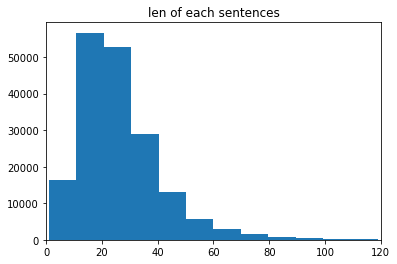

In [118]:
plt.hist(sentences_lens, bins=30)
plt.title('len of each sentences')
plt.xlim([0, 120]);

In [121]:
output_seg_len = int(np.percentile(sentences_lens, 95)) # 95% percentile (make sure don't cut many information off)
output_seg_len # just missed 5% 

55

text_vectorizer: text to number (like ordinal encoder)

In [122]:
#create text vectorizer layer (text to number)
max_vocab = 68000 # from the paper

In [126]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_vocab, 
                             output_sequence_length=output_seg_len)

#adapt to training data
text_vectorizer.adapt(train_sentences)

In [159]:
#test out text_vectorizer
import random
sample = random.choice(train_sentences)
print(f'Text:\n{sample}\n')
print(f'Length of text: {len(sample)}')
print(f'Vectorized:\n{text_vectorizer(sample)}')

Text:
the vast majority labeled the person with drug dependence as an addict , rated them as having undesirable characteristics , and expressed a strong desire for social distance .

Length of text: 175
Vectorized:
[    2 12307  1494  7668     2  3117     7   300  1725    25    26 41409
  1735   942    25   956 12319   395     3  2281     8  1469  4332    11
   457  1167     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0]


In [149]:
# how many word in training
vocab_list = text_vectorizer.get_vocabulary()
length_vocab = len(vocab_list)
print('Number of vocab :',length_vocab)
print('Most common word :',vocab_list[:10])
print('Least common word :',vocab_list[-10:])

Number of vocab : 64841
Most common word : ['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were']
Least common word : ['aarm', 'aaqol', 'aaq', 'aanhui', 'aana', 'aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


embedding: (relavent number word by word, randomize number first and train like weights)

In [190]:
#token embedding layer
token_embed = layers.Embedding(input_dim=length_vocab, 
                               output_dim=128, # dimetion of output
                               mask_zero= True, # will do more efficient computing (when a lot of zero in matrix)
                               name='token_embedding')

In [191]:
#show example embeding
print(f'Text : {sample}')
vec_sample = text_vectorizer([sample])
print(f'Vectorized:\n{vec_sample}')
print(f' shape : {vec_sample.shape}\n')
em_sample = token_embed(vec_sample)
print(f'Embedded:\n{em_sample[0,:5,:6]}')
print(f' shape : {em_sample.shape}')

Text : the vast majority labeled the person with drug dependence as an addict , rated them as having undesirable characteristics , and expressed a strong desire for social distance .
Vectorized:
[[    2 12307  1494  7668     2  3117     7   300  1725    25    26 41409
   1735   942    25   956 12319   395     3  2281     8  1469  4332    11
    457  1167     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]
 shape : (1, 55)

Embedded:
[[-0.0250766   0.04940087  0.01752467  0.00150656 -0.03600333 -0.04384569]
 [-0.01981711  0.02298809  0.04898243  0.00622345  0.03943354  0.03833044]
 [ 0.04184414  0.04992813 -0.03718726 -0.0463817  -0.02895577  0.02130698]
 [-0.02842206  0.02443748  0.02938204 -0.04831958  0.0142054  -0.04196916]
 [-0.0250766   0.04940087  0.01752467  0.00150656 -0.03600333 -0.04384569]]
 shape : (1, 55, 128)


0.476

<h5>Create datasets : making more efficient to load and train model</h5>

In [192]:
#Turn out data into Tensorflow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [193]:
#making more efficien to load and train model
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # auto prefetch many as you can
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # auto prefetch many as you can
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # auto prefetch many as you can

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Model 1 : ConV1D

In [197]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vector = text_vectorizer(inputs)
token_embeder = token_embed(text_vector)
x = layers.Conv1D(filters=32, kernel_size=5, padding='same', activation='relu')(token_embeder)
x = layers.GlobalAveragePooling1D()(x) 
outputs = layers.Dense(5, activation='softmax')(x)
model_1 = keras.Model(inputs, outputs)

model_1.summary()
model_1.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)
hist_1 = model_1.fit(train_dataset, 
                     validation_data=val_dataset, 
                     steps_per_epoch=int(len(train_dataset) *.1),
                     validation_steps = int(len(val_dataset) *.1),
                     epochs=5)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 55)               0         
 ectorization)                                                   
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d_4 (Conv1D)           (None, 55, 32)            20512     
                                                                 
 global_average_pooling1d_2   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 5)                 165 

In [199]:
model_1_proba = model_1.predict(val_dataset)
model_1_preds = tf.argmax(model_1_proba, axis=1)
print(model_1_preds[:5])

tf.Tensor([0 0 3 2 2], shape=(5,), dtype=int64)


In [201]:
model_1_result = evaluate_score(val_labels_, model_1_preds)
model_1_result

{'accuracy': 0.7999139414802066,
 'precision': 0.7999927771213171,
 'recall': 0.7999139414802066,
 'f1_score': 0.7967508114490842}

6.719